In [1]:
import re
import os
import warnings
from functools import reduce
from collections import defaultdict
from unicodedata import normalize
from math import ceil
from pprint import pprint
from tqdm import tqdm #progress bar lib

import pandas as pd
import numpy as np
import sklearn
from sklearn import cluster as cl
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.datasets import load_iris

import tensorflow as tf
import tflearn

import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

In [2]:
def values(data): return np.array([x for x in data.values])

def transpose(data): return [list(i) for i in zip(*data)]

def onehot(data): 
    """ returns a one-hot encoding of 'data' even if 'data''s elements are lists """
    all_items = list()
    new_items = list()
    if all([i==type([]) for i in data]): #if every element in 'data' is a list
        for l in data:
            for item in l:
                if item not in all_items:
                    all_items.append(item)
        for l in data:
            items_for_movie = list()
            for item in all_items:
                items_for_movie.append(float(item in l))
            new_items.append(items_for_movie)
    elif not any([i==type([]) for i in data]): #if every element is not a list
        for item in data:
            if item not in all_items:
                all_items.append(item)
        for item in data:
            items_for_movie = list()
            for check_item in all_items:
                items_for_movie.append(float(check_item==item))
            new_items.append(items_for_movie)
    else:
        raise TypeError("Mismatched lists and non-lists in 'data'")
    return new_items

In [3]:
# read data from provided excel spreadsheets
nonadhd = pd.read_excel("adhd_data.xlsx", sheetname=0)
adhd = pd.read_excel("adhd_data.xlsx", sheetname=1)
#ignore SetWithCopyWarning
pd.options.mode.chained_assignment = None
nonadhd["ADHD"] = ["0" for _ in range(len(nonadhd["GENDER"]))]
adhd["ADHD"] = ["1" for _ in range(len(adhd["GENDER"]))]
csv = pd.concat([adhd, nonadhd], ignore_index=True)

csv["GENDER"] = onehot(csv["GENDER"])
csv = csv.reindex(np.random.permutation(csv.index)) # shuffle rows
features = csv[::]

lenList = list()
flatfeatures = list()
features["M"] = [x for x,_ in features["GENDER"]]
features["F"] = [x for _,x in features["GENDER"]]
delete_vals = ["GENDER", "ADHD", "GROUP", "FILE", "DISTR", "IMP", "RAND", "MIN", "CONT", "SEX", "ATTN"]
 # deletes clinical group, sex/gender (already one-hot-ed this) and computed values from test's model
adhd_target = features[["GROUP"]]
for i in delete_vals: del features[i]
feature_names = features.columns.values
features = values(features)
adhd_target = values(adhd_target)

## Supervised Learning

In [4]:
#some code from http://scikit-learn.org/0.18/auto_examples/classification/plot_classifier_comparison.html

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


default_classifiers = [KNeighborsClassifier(n_neighbors=10), SVC(kernel="linear"),
                       SVC(C=1), GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
                       DecisionTreeClassifier(), RandomForestClassifier(), MLPClassifier(),
                       AdaBoostClassifier(n_estimators=20), GaussianNB(), 
                       QuadraticDiscriminantAnalysis(tol=0.1)]

class AggregateModels(object):
    def __init__(self, split=0.75, trials=20, classifiersRepl={}, namesRepl={}):
        """AggregateModel class used for testing accuracy of each model easily.
        Arguments:
            'split' is the training/testing splt for the data
            'trials' is the number of trials
            'classifiersRepl' is a either:
                a dict of ints and classifier classes and replaces default classifiers
                    with indexes corresponding to classifierRepl's keys
                a list of classifiers which sets up a new classifier batch
            'namesRepl' act in the same way as classifiersRepl but with classifier names
        Methods:
            scale_data: scales the data for use in a gaussian model
            evaluate_model: trainins and outputs accuracy of a given model 
            run: runs all the models that the class has provided and outputs accuracy and histogram
        """
        
        self.split = split
        self.trials = trials
        
        if type(classifiersRepl)==type({}):
            # replaces classifers with corresponding classifers in classifiersRepl if dict
            classifiers = default_classifiers[:]
            for key, value in classifiersRepl.items():
                classifiers[key]=value
            self.classifiers_factory = lambda: classifiers[:]
        else:
            # otherwise defines classifiers based on parameter
            assert type(classifiersRepl)==type([])
            self.classifiers_factory = lambda: classifiersRepl[:]
        
        # similar behavior as classifiersRepl
        if type(namesRepl)==type({}):
            self.names = [re.findall(r"(\w+)\(", str(classifier))[0] 
                          for classifier in self.classifiers_factory()]
            self.names = [x.replace("Classifier","") for x in self.names]
            # the above two operations extract the classifer name from the stringified classname
            for key, value in namesRepl.items():
                self.names[key]=value
        elif type(namesRepl)==type([]):
            self.names = names
        else:
            raise TypeError
        
        self.example_models = {name:None for name in self.names}
        self.model_performance = defaultdict(list)
        self.training_model_performance = defaultdict(list)
    
    def scale_data(self, data):
        return StandardScaler().fit_transform(data)

    def evaluate_model(self, model, features, targets, test_features, test_targets, testTraining=False):
        model.fit(features, targets)
        if testTraining:
            accuracy = np.sum(np.array([a==b for a,b in zip(
                        map(model.predict, features), targets)], np.float64))/len(targets)
        else:
            accuracy = np.sum(np.array([a==b for a,b in zip(
                        map(model.predict, test_features), test_targets)], np.float64))/len(test_targets)
        return accuracy
    
    def run(self):
        warnings.filterwarnings("ignore") #ignore Pandas warning for this func only
        # runs the model with parameters set up on class init
        for trial in tqdm(range(self.trials)):
            training_set, test, labels_train, labels_test = \
            sklearn.model_selection.train_test_split(
                features, adhd_target, train_size=self.split)

            training_set = self.scale_data(training_set)
            test = self.scale_data(test)

            classifiers = self.classifiers_factory()
            for name, classifier in zip(self.names, classifiers):
                self.model_performance[name].append(
                    self.evaluate_model(classifier, training_set, labels_train, test, labels_test))
                self.training_model_performance[name].append(
                    self.evaluate_model(
                        classifier, training_set, labels_train, test, labels_test, testTraining=True))
                if trial == self.trials-1:
                    self.example_models[name] = classifier
        warnings.filterwarnings("default") #set warnings back to normal
        # print testing results
        max_nameLength = max(map(len, self.names))
        round_accuracy = lambda value: str(100*sum(value)/self.trials)[:5]+"%"
        
        print(3*"="+" Validation on Testing Data "+3*"=")
        for key, value in sorted(self.model_performance.items(), key=lambda i: sum(i[1]), reverse=True):
            # prettyprints each datapoint so that it's center-aligned
            print((key+": ").rjust(max_nameLength+5)+(round_accuracy(value)).ljust(10))

        print("\n"+3*"="+" Validation on Training Data "+3*"=")
        for key, value in sorted(self.training_model_performance.items(), key=lambda i: sum(i[1]), reverse=True):
            print((key+": ").rjust(max_nameLength+5)+(round_accuracy(value)).ljust(10))

        for name in self.names:
            # plots accuracy of each model
            pd.Series(self.model_performance[name]).plot.kde(label=name)
        plt.legend(loc='upper left', shadow=True)
        plt.xlim(0.5,1)
        plt.show()

100%|██████████| 50/50 [01:13<00:00,  1.70s/it]


=== Validation on Testing Data ===
   GaussianProcess: 99.49%    
        Linear SVM: 99.45%    
               SVM: 98.78%    
               MLP: 98.58%    
          AdaBoost: 94.70%    
        KNeighbors: 92.82%    
      DecisionTree: 90.39%    
      RandomForest: 90.15%    
               QDA: 88.82%    
        GaussianNB: 84.39%    

=== Validation on Training Data ===
          AdaBoost: 100.0%    
   GaussianProcess: 100.0%    
               MLP: 100.0%    
      DecisionTree: 100.0%    
        Linear SVM: 100.0%    
               SVM: 99.96%    
      RandomForest: 99.70%    
               QDA: 99.24%    
        KNeighbors: 94.54%    
        GaussianNB: 86.87%    


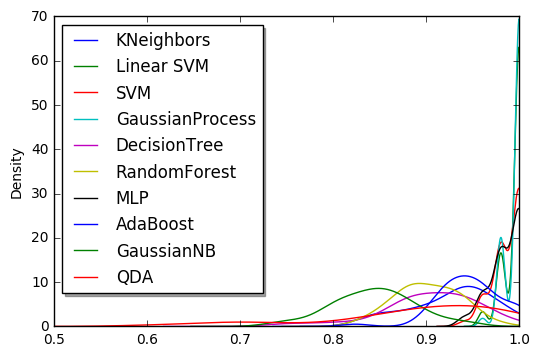

In [5]:
# standard configuration of AggregateModels
model1 = AggregateModels(split=0.75, trials=50, 
                         namesRepl={2:"SVM", 1:"Linear SVM", 9:"QDA"})
model1.run()

100%|██████████| 2/2 [00:19<00:00,  9.74s/it]


=== Validation on Testing Data ===
        Linear SVM: 90.93%    
   GaussianProcess: 86.53%    
        GaussianNB: 84.06%    
               MLP: 83.79%    
          AdaBoost: 82.96%    
               SVM: 82.69%    
      RandomForest: 80.49%    
      DecisionTree: 79.94%    
               QDA: 69.50%    
        KNeighbors: 57.96%    

=== Validation on Training Data ===
               QDA: 100.0%    
          AdaBoost: 100.0%    
   GaussianProcess: 100.0%    
               SVM: 100.0%    
      RandomForest: 100.0%    
               MLP: 100.0%    
      DecisionTree: 100.0%    
        Linear SVM: 100.0%    
        GaussianNB: 95.0%     
        KNeighbors: 72.5%     


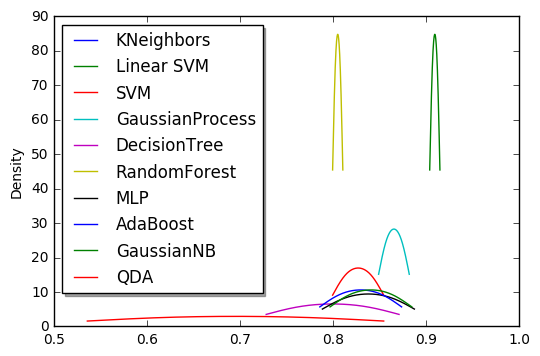

In [8]:
# this configuration tests models with only 10% of the training data
model2 = AggregateModels(split=0.1, trials=2, \
                         namesRepl={2:"SVM", 1:"Linear SVM", 9:"QDA"}, \
                         classifiersRepl={5:RandomForestClassifier(n_estimators=500)})
model2.run()

In [9]:
# SEE: https://arxiv.org/abs/1602.04938

import random
from lime import lime_tabular

test_agg_model = model1
example_model=test_agg_model.example_models["RandomForest"]

warnings.filterwarnings("ignore") # the LIME API throws warnings in python3
explainer = lime_tabular.LimeTabularExplainer(
                    features, feature_names=feature_names, class_names=["0","1"])

i = np.random.randint(0, features.shape[0])
exp = explainer.explain_instance(features[i], example_model.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)
example_model.predict_proba(features[i])
warnings.filterwarnings("default")

## Unsupervised Learning

In [10]:
def clusterData(training_set, to_search, model=cl.KMeans(), plot_model=True, plot_labels=True, returnDict=False):
    " Uses a provided sklearn clustering algorithm to cluster and analyze a dataset "
    search_list = [[item.strip() for item in subset] for subset in [x.split("=") 
                    for x in to_search.split(",")]]
    model.fit(training_set)
    labels = model.labels_
    labels_list = list()
    label_dictList=[]
    for key, value in search_list: #for every parameter
        # seraches and prepares data for analysis and clustering
        indiv_list = list()
        matched_row = csv[csv[key]==float(value)]
        indexes = list(matched_row.index)
        label_dict = {label:[] for label in list(
                set([labels[index] for index in indexes if index<len(labels)]))}
        for index in indexes:
            try:
                indiv_list.append(labels[index])
                label_dict[labels[index]].append( #adds movie title to label_dict
                    normalize("NFKD", csv.loc[[index]]["FILE"].values[0]).strip())
            except IndexError:
                continue
        labels_list.append(indiv_list)
        label_dictList.append(label_dict)
    
    if plot_model or plot_labels:
        # creates adequate number of subplots for each parameter
        f, axarr = plt.subplots(ceil((len(labels_list)-1)/2)+int(plot_model),
                                1+int(plot_model and plot_labels))
    
    if plot_model:
        # plots histogram of lables vs number of entries for each label
        model_labels = list(set(labels))
        counts = [list(labels).count(x) for x in model_labels]
        D = {k:v for k, v in zip(model_labels, counts)}
        try:
            ax = axarr[0,0]
        except IndexError:
            ax = axarr[0]
        ax.bar(range(len(D)), D.values(), align='center')
        ax.set_xticks(range(len(D)), D.keys())
        ax.set_ylabel('Number of Occurances')
        ax.set_title('Model Histogram')
        
    if plot_labels:
        # plots histogram for each label
        for ind, occurance in enumerate(labels_list):
            occuranceLabels = list(set(occurance))
            counts = [list(occurance).count(x) for x in occuranceLabels]
            D = {k:v for k, v in zip(occuranceLabels, counts)}
            try:
                ax = axarr[(ind+int(plot_model))//2,(ind+int(plot_model))%2]
            except IndexError:
                ax = axarr[1]
            ax.bar(range(len(D)), D.values(), align='center')
            ax.set_xticks(range(len(D)), D.keys())
            ax.set_ylabel('Number of Occurances')
            ax.set_title('Histogram for '+str(search_list[ind][1]))
            
        if ind%2 == 1: # if there is a leftover square, fill in "NO DATA"
            axarr[(ind+int(plot_model))//2, 1].text(0.5, 0.5,
                                                ' '*65+'NO DATA',#spacing
                                                horizontalalignment='center',
                                                verticalalignment='center',
                                                fontsize=20, color='red',
                                                transform=ax.transAxes)
    plt.tight_layout()
    if returnDict:
        return label_dictList

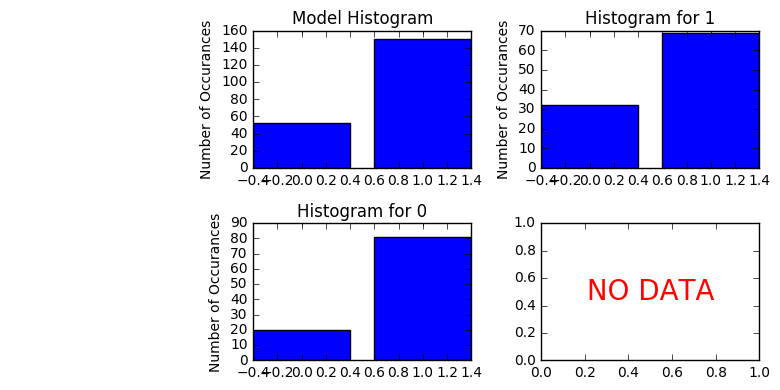

In [13]:
clusterData(features, "GROUP=1, GROUP=0", model=cl.AgglomerativeClustering(n_clusters=2))

In [19]:
# simple regression with tensorflow

def trainTensorflow():
    training_set, test, labels_train, labels_test = \
            sklearn.model_selection.train_test_split(
                features, adhd_target, train_size=0.75)
    
    W = tf.Variable(tf.zeros([16, 2]), name="weights")
    b = tf.Variable(tf.zeros([2], name="bias", dtype="float32"))

    def loss(X, Y):
        return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(tf.matmul(X, W) + b, Y))

    def train(total_loss):
        learning_rate = 0.01
        return tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)

    def evaluate(sess, X, Y):
        predicted = tf.cast(tf.arg_max(tf.nn.softmax(tf.matmul(X, W) + b), 1), tf.int32)
        print(sess.run(tf.reduce_mean(tf.cast(tf.equal(predicted, Y), tf.float32))))

    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        X, Y = np.array(training_set, dtype="float32"), \
               np.array(np.rint(np.array(
                        [i[0] for i in labels_train])), dtype="int32")

        total_loss = loss(X, Y)
        train_op = train(total_loss)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        training_steps = 10000
        for step in range(training_steps):
            sess.run([train_op])
            if step % 1000 == 0:
                print("loss: ", sess.run(total_loss))

        evaluate(sess, X, Y)
        coord.request_stop()
        coord.join(threads)
        sess.close()

trainTensorflow()

loss:  10164.2
loss:  4388.14
loss:  833.599
loss:  858.055
loss:  6222.16
loss:  547.358
loss:  4229.22
loss:  581.754
loss:  1478.64
loss:  553.376
0.89404
